In [1]:
import os
import sys
import numpy as np
import re
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pickle
from torch.nn.utils.rnn import pad_sequence
from unicodedata import normalize
from keras.preprocessing.text import Tokenizer
import keras
from torchvision import transforms, datasets
from tqdm import tqdm
from time import sleep
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import pylab as pl
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [67]:
ids_achados   = pd.read_csv('../../greenZoneIds.csv', index_col = 0)
base = pd.read_csv("../../../data/DATA_LAUDOS_TEXTO_formato1", sep = ";")

In [74]:
resultLabels   = pd.read_csv('../../../data/resultLabels.csv')
scores = resultLabels
scores = scores[scores["idExame"].isin(ids_achados['id'])]
scores = [[0 if ("False" in i) else 1 for i in row.split(",")] for row in scores["label"][-50000:]]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/jonas/anaconda3/lib/python3.7/site-packages/pandas/io/parsers.py", line 1995, in read
    data = self._reader.read(nrows)
  File "pandas/_libs/parsers.pyx", line 899, in pandas._libs.parsers.TextReader.read
  File "pandas/_libs/parsers.pyx", line 914, in pandas._libs.parsers.TextReader._read_low_memory
  File "pandas/_libs/parsers.pyx", line 991, in pandas._libs.parsers.TextReader._read_rows
  File "pandas/_libs/parsers.pyx", line 1123, in pandas._libs.parsers.TextReader._convert_column_data
  File "pandas/_libs/parsers.pyx", line 1169, in pandas._libs.parsers.TextReader._convert_tokens
  File "pandas/_libs/parsers.pyx", line 1215, in pandas._libs.parsers.TextReader._convert_with_dtype
  File "/home/jonas/anaconda3/lib/python3.7/site-packages/pandas/core/dtypes/common.py", line 572, in is_categorical_dtype
    def is_categorical_dtype(arr_or_dtype):
KeyboardInterrupt

During handling of the above exception, another exception occurred:

T

KeyboardInterrupt: 

In [77]:
scores = np.array(scores)

In [83]:
for i in range(74):
    print(i, ":", scores[:,i].sum())

0 : 494
1 : 19011
2 : 10965
3 : 806
4 : 0
5 : 1761
6 : 1
7 : 2097
8 : 169
9 : 59
10 : 5
11 : 640
12 : 20
13 : 1043
14 : 31
15 : 3
16 : 1
17 : 11
18 : 126
19 : 204
20 : 3030
21 : 223
22 : 3275
23 : 3444
24 : 1454
25 : 49530
26 : 0
27 : 2254
28 : 5305
29 : 224
30 : 1
31 : 0
32 : 0
33 : 38
34 : 47
35 : 10
36 : 1
37 : 2184
38 : 1
39 : 21614
40 : 1003
41 : 136
42 : 4367
43 : 15
44 : 2881
45 : 1408
46 : 9
47 : 30
48 : 18
49 : 0
50 : 10
51 : 38
52 : 8
53 : 10
54 : 98
55 : 39
56 : 0
57 : 46
58 : 1
59 : 97
60 : 3173
61 : 34
62 : 4
63 : 146
64 : 249
65 : 1490
66 : 16
67 : 15
68 : 1
69 : 0
70 : 0
71 : 0
72 : 1
73 : 1


In [5]:
corte_classes = [84, 85, 96, 84, 97, 94, 81, 100, 83, 95, 83, 83, 81, 92, 95, 81, 85, 92, 84, 83, 86, 89, 83, 92, 93, 92, 83, 83, 87, 
                100, 92, 80, 84, 87, 91, 84, 100, 81, 100, 100, 88, 100, 81, 90, 100, 83, 90, 81, 86, 83, 96, 82, 97, 85, 90, 81, 81, 97,
                95, 97, 84, 81, 84, 89, 86, 89, 83, 95]
ordem_classes = ['área_eletricamente_inativa',
       'Bloqueio_de_ramo_direito', 'Bloqueio_de_ramo_esquerdo',
       'Bloqueio_de_ramo_direito_e_bloqueio_divisional_anterossuperior_do_ramo_esquerdo',
       'Bloqueio_intraventricular_inespecífico',
       'Sobrecarga_ventricular_esquerda_(critérios_de_Romhilt-Estes)',
       'Sobrecarga_ventricular_esquerda_(critérios_de_voltagem)',
       'Fibrilação_atrial', 'Flutter_atrial',
       'Bloqueio_atrioventricular_de_2°_grau_Mobitz_I',
       'Bloqueio_atrioventricular_de_2°_grau_Mobitz_II',
       'Bloqueio_atrioventricular_2:1', 'Bloqueio_atrioventricular_avançado',
       'Bloqueio_atrioventricular_total',
       'Pré-excitação_ventricular_tipo_Wolff-Parkinson-White',
       'Sistema_de_estimulação_cardíaca_normofuncionante',
       'Sistema_de_estimulação_cardíaca_com_disfunção',
       'Taquicardia_atrial_multifocal', 'Taquicardia_atrial',
       'Taquicardia_supraventricular', 'Corrente_de_lesão_subendocárdica',
       'Alterações_primárias_da_repolarização_ventricular',
       'Extrassístoles_supraventriculares', 'Extrassístoles_ventriculares',
       'Bradicardia_sinusal',
       'ECG_dentro_dos_limites_da_normalidade_para_idade_e_sexo',
       'Alterações_da_repolarização_ventricular_atribuídas_à_ação_digitálica',
       'Alterações_inespecíficas_da_repolarização_ventricular',
       'Alterações_secundárias_da_repolarização_ventricular',
       'Arritmia_sinusal',
       'Ausência_de_sinal_eletrocardiográfico_que_impede_a_análise',
       'Interferência_na_linha_de_base_que_não_impede_a_análise_do_ECG',
       'Ausência_de_sinal_eletrocardiográfico_que_não_impede_a_análise',
       'Traçado_com_qualidade_técnica_insuficiente',
       'Possível_inversão_de_posicionamento_de_eletrodos',
       'Baixa_voltagem_em_derivações_precordiais',
       'Baixa_voltagem_em_derivações_periféricas',
       'Bloqueio_atrioventricular_de_1°_grau',
       'Bloqueio_de_ramo_direito_e_bloqueio_divisional_posteroinferior_do_ramo_esquerdo',
       'Bloqueio_divisional_anterossuperior_do_ramo_esquerdo',
       'Bloqueio_divisional_posteroinferior_do_ramo_esquerdo',
       'Desvio_do_eixo_do_QRS_para_direita',
       'Desvio_do_eixo_do_QRS_para_esquerda',
       'Dissociação_atrioventricular_isorrítmica',
       'Distúrbio_de_condução_do_ramo_direito',
       'Distúrbio_de_condução_do_ramo_esquerdo', 'Intervalo_PR_curto',
       'Intervalo_QT_prolongado', 'Isquemia_subendocárdica',
       'Progressão_lenta_de_R_nas_derivações_precordiais', 'Pausa_sinusal',
       'Corrente_de_lesão_subepicárdica',
       'Corrente_de_lesão_subepicárdica_-_provável_infarto_agudo_do_miocárdio_com_supradesnivelamento_de_ST',
       'Repolarização_precoce', 'Ritmo_atrial_ectópico',
       'Ritmo_atrial_multifocal', 'Ritmo_idioventricular_acelerado',
       'Ritmo_juncional', 'Síndrome_de_Brugada', 'Sobrecarga_atrial_direita',
       'Sobrecarga_atrial_esquerda', 'Sobrecarga_biatrial',
       'Sobrecarga_biventricular', 'Sobrecarga_ventricular_direita',
       'Sobrecarga_ventricular_esquerda(_critérios_de_voltagem)',
       'Taquicardia_sinusal', 'Taquicardia_ventricular_não_sustentada',
       'Taquicardia_ventricular_sustentada',
       'Suspeita_de_Síndrome_de_Brugada_repetir_V1-V2_em_derivações_superiores',
       'Taquicardia_juncional', 'Batimento_de_escape_atrial',
       'Batimento_de_escape_supraventricular', 'Batimento_de_escape_juncional',
       'Batimento_de_escape_ventricular']

In [6]:
# Global variables
REBUILD_DATA = False
TOP_WORDS = 7500
EPOCHS = 30 
BATCH_SIZE = 256
#Essa variável aqui é o número de posições que os vetores tem ao usar o pad_sequences. Não uso ela pra nada ainda mas talvez eu venha a usar, por isso ela está aqui.
SEQ_SIZE = 422

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on a GPU :D")
else:
    device = torch.device("cpu")
    print("Running on a CPU :/")

Running on a GPU :D


In [8]:
# Oi, Derick
# To comentando como diálogo porque acho mais fácil explicar o código assim. Se o comentário estiver errado é pq essa é a parte que eu entendi errado.
class Net(nn.Module):
    def __init__(self):
        
        print("Building NN...")
        embedding_dim = 128
        lstm_out_dim = 128
        num_embeddings = 7500
        num_of_classes = 74
        
        super().__init__()
        #Camada de Embedding, o padding_idx é um argumento que eu descobri que é usada para falar para a camada que os números no fim de cada vetor são apenas lixo
        self.l1 = nn.Embedding(num_embeddings, embedding_dim, padding_idx = 0)
        #Eu não entendo muito bem o que essa camada faz. Pelo que eu entendi é algo probabilístico. Mas ela n altera o shape.
        self.l2 = nn.Dropout(p=0.4)
        #A LSTM recebe os Embeddings e cospe o mesmo número de vetores que eu passei para ela. Não sei se eu deveria alterar o número de camadas da LSTM.
        #Se usar menos de 2 não dá pra colocar Dropout pq o Dropout é aplicado em todas as camadas menos na última.
        self.l3 = nn.LSTM(embedding_dim, lstm_out_dim, dropout = 0.2, num_layers = 2)
        #É o seguinte. Como as dimensões de entrada são estáticas, eu adicionei elas manualmente na camada linear para conseguir fazer o flatten.
        self.l4 = nn.Flatten()
        #Dimensao do vetor de entrada X dimensao da lstm
        self.l5 = nn.Linear(SEQ_SIZE * lstm_out_dim, num_of_classes)
        
    
    def forward(self, x):
        #Aqui eu só to passando o input pelas camadas mesmo
        x    = self.l1(x)
        x    = self.l2(x)
        #A camada de LSTM retorna uma tupla, o vetor que eu quero é a primeira posição da tupla, por isso recebo assim.
        #Acho que a segunda camada da LSTM só é util ao passar de uma camada da LSTM para a outra.
        x, _ = self.l3(x)
        x    = self.l4(x)
        x    = self.l5(x)
        #Aqui eu aplico o softmax. Especifico o número de dimensões para ser um e tal. Não sei o que não está funcionando :c.
        x    = F.softmax(x, dim = 1)
            
        return x        

In [9]:
def clean_text(x):
    if type(x) is str:
        pattern = r'[^a-zA-z0-9!.?,:\s]'
        x = normalize('NFKD', x).encode('ASCII', 'ignore').decode('ASCII')
        x = re.sub(pattern, '', x)
        return x
    else:
        return ""

In [10]:
def tokenize(text, tokenizer, fit = False):
    # Creating vocabulary
    if fit:
        tokenizer.fit_on_texts(text)
    # Vectorizing text
    train_X   = tokenizer.texts_to_sequences(text)
    return train_X

In [13]:
with open("../../trained_models/pytorch_tokenizer.pickle", 'rb') as handle:
    tokenizer = pickle.load(handle)

In [16]:
#Atribua aqui sua validação
base = base[base['ID_EXAME'].isin(ids_achados['id'])]
print(len(base))
text = base["CONTEUDO"][-50000:]
print(len(text))

675940
50000


In [17]:
text        = [clean_text(i) for i in text]
test_X_temp = tokenize(text, tokenizer, fit = False)
test_X_temp = [torch.Tensor(i).type(torch.LongTensor) for i in test_X_temp]
test_X_temp = pad_sequence(test_X_temp, batch_first=True).type(torch.LongTensor)

In [32]:
test_X = []
if(len(test_X_temp[0]) < 422):
    for i in range(len(test_X_temp)):
        line = test_X_temp[i]
        for j in range(422 - len(line)):
            line = torch.cat((line, torch.Tensor([0]).type(torch.LongTensor)), 0)
        test_X.append(line)
else:
    test_X = [line[:422] for line in test_X_temp]
    
test_X = torch.stack([i for i in test_X])

In [15]:
# labels = [row[1:-1] for row in resultLabels['label']]
# labels = [label.split(',') for label in labels]
# labels = [[1 if word == " True" or word == "True" else 0 for word in row] for row in labels]
# test_y = labels[-50000:]

In [35]:
net = Net()
net.load_state_dict(torch.load("../../trained_models/pytorch_checkpoint_2.pth",  map_location=torch.device('cpu')))
net.eval()

Building NN...


Net(
  (l1): Embedding(7500, 128, padding_idx=0)
  (l2): Dropout(p=0.4, inplace=False)
  (l3): LSTM(128, 128, num_layers=2, dropout=0.2)
  (l4): Flatten()
  (l5): Linear(in_features=54016, out_features=74, bias=True)
)

In [54]:
finalResult = torch.Tensor()
size = 64
for i in range(0, 50000, size):
    if(i % 1024 == 0):
        print(i, " -> ", i+1024)
    with torch.no_grad():
        result      = net(test_X[i:min(i+size, 50000)])
    finalResult = torch.cat((finalResult, result), 0)

0  ->  1024
1024  ->  2048
2048  ->  3072
3072  ->  4096
4096  ->  5120
5120  ->  6144
6144  ->  7168
7168  ->  8192
8192  ->  9216
9216  ->  10240
10240  ->  11264
11264  ->  12288
12288  ->  13312
13312  ->  14336
14336  ->  15360
15360  ->  16384
16384  ->  17408
17408  ->  18432
18432  ->  19456
19456  ->  20480
20480  ->  21504
21504  ->  22528
22528  ->  23552
23552  ->  24576
24576  ->  25600
25600  ->  26624
26624  ->  27648
27648  ->  28672
28672  ->  29696
29696  ->  30720
30720  ->  31744
31744  ->  32768
32768  ->  33792
33792  ->  34816
34816  ->  35840
35840  ->  36864
36864  ->  37888
37888  ->  38912
38912  ->  39936
39936  ->  40960
40960  ->  41984
41984  ->  43008
43008  ->  44032
44032  ->  45056
45056  ->  46080
46080  ->  47104
47104  ->  48128
48128  ->  49152
49152  ->  50176


In [65]:
for i in range(74):
    print(i, " : ", finalResult[:,i].sum())

0  :  tensor(5.7201)
1  :  tensor(16425.9766)
2  :  tensor(10764.5957)
3  :  tensor(3.5111)
4  :  tensor(0.0161)
5  :  tensor(96.3639)
6  :  tensor(0.0283)
7  :  tensor(29.7678)
8  :  tensor(0.0001)
9  :  tensor(0.7182)
10  :  tensor(0.0054)
11  :  tensor(0.0136)
12  :  tensor(0.0116)
13  :  tensor(58.3386)
14  :  tensor(6.5624)
15  :  tensor(0.6439)
16  :  tensor(0.0014)
17  :  tensor(0.0001)
18  :  tensor(1.1717)
19  :  tensor(81.1049)
20  :  tensor(22.9402)
21  :  tensor(17.7296)
22  :  tensor(77.4629)
23  :  tensor(18.3679)
24  :  tensor(0.0001)
25  :  tensor(14.3632)
26  :  tensor(0.0006)
27  :  tensor(35.6089)
28  :  tensor(0.0005)
29  :  tensor(0.0001)
30  :  tensor(1.0789)
31  :  tensor(0.0001)
32  :  tensor(0.0001)
33  :  tensor(0.0075)
34  :  tensor(0.0001)
35  :  tensor(0.0136)
36  :  tensor(0.0032)
37  :  tensor(14.2187)
38  :  tensor(0.0026)
39  :  tensor(17880.8027)
40  :  tensor(654.4205)
41  :  tensor(1.5982)
42  :  tensor(8.5315)
43  :  tensor(0.0696)
44  :  tensor(170

In [39]:
n_classes = 74
y_test = np.array(test_y)
y_score = finalResult.numpy()

In [44]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])

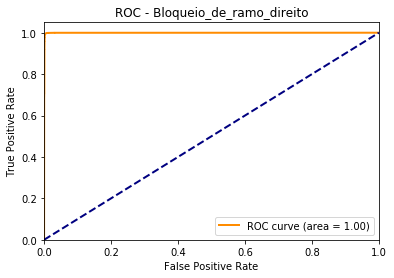

<Figure size 432x288 with 0 Axes>

In [73]:
nClass = 3
plt.figure()
lw = 2
plt.plot(fpr[nClass], tpr[nClass], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[nClass])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - ' + ordem_classes[nClass])
plt.legend(loc="lower right")
plt.savefig('../../../data/test_data/ROC/' + ordem_classes[nClass] + '.png')
plt.show()